# Feature Engineering

## 1. Import Dependencies

In [1]:
# utilities
import os
import random
import pickle
from tqdm import tqdm

# data loading and manipulation
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import KeyedVectors
import fasttext.util
# Visualize with t-SNE or PCA
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
import zipfile

## 2. Utility Functions

In [3]:
from typing import List

label_dict = {
    0 : "business",
    1 : "tech",
    2 : "politics",
    3 : "sport",
    4 : "entertainment"
}

In [2]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [4]:
def save_embeddings(save_folder, file_name, embeddings):
    try:
        SAVE_PATH = os.path.join(save_folder, file_name)
        with open(SAVE_PATH, 'wb') as f:
            pickle.dump(embeddings, f)
        print(f"Successfully saved at : {SAVE_PATH}")
    except Exception as e:
        raise e

In [5]:
def load_embeddings(save_folder, file_name):
    try:
        SAVE_PATH = os.path.join(save_folder, file_name)
        with open(SAVE_PATH, 'rb') as f:
            word2vec_data = pickle.load(f)
        print(f"Loaded from : {SAVE_PATH}")
        return word2vec_data
    except Exception as e:
        raise e

## 3. Load the Dataset

In [25]:
DATA_PATH = os.path.join(os.getcwd(), "data")
SAVE_PATH  = os.path.join(os.getcwd(), "embeddings")

In [8]:
train_df = pd.read_csv(os.path.join(DATA_PATH, "train_data_cleaned.csv"))
train_df.head()

,ArticleId,Text,Category,Clean_text,Label
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex bos launch defence lawyer defend f...,0
1,154,german business confidence slides german busin...,business,german business confidence slide german busine...,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicate economic gloom citizen major...,0
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster well fu...,1
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss payout eighteen former enron direct...,0


In [9]:
train_df["Token_length"] = train_df["Clean_text"].map(lambda x: len(x.split()))

In [10]:
# dependent and independent features
texts = train_df.drop(['ArticleId', 'Text', 'Category', 'Label'], axis=1)
labels = train_df['Label'].values

In [12]:
# Stratified split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels
)

## 1. One-Hot Encoding

**Steps:**
1. **Create a vocabulary:** A vocabulary is a list of unique words from your corpus (the entire set of documents).

2. **Generate one-hot vectors:** For each word in the corpus, create a vector of zeros where the index corresponding to that word in the vocabulary is set to 1.

In [15]:
corpus = train_texts["Clean_text"].to_list()

In [16]:
# Step 1: Create a vocabulary (a set of unique words)
def create_vocabulary(corpus):
    vocabulary = set()
    for text in corpus:
        words = text.split()  # Convert to lower case and split by spaces
        vocabulary.update(words)
    return sorted(vocabulary)

In [17]:
# Create the vocabulary
vocabulary = create_vocabulary(corpus)
vocabulary.append('<UNK>')

In [18]:
# unknown word not present in train but present in test
vocabulary[-1]

'<UNK>'

In [19]:
print("Vocabulary:", vocabulary[1000:1010])

Vocabulary: ['atomic', 'atomstroieksport', 'aton', 'atp', 'atr', 'att', 'attach', 'attachment', 'attack', 'attacked']


In [20]:
# Step 2: One-hot encoding function
def one_hot_encode(corpus, vocabulary):
    # Create a mapping of words to their respective indices in the vocabulary
    word_to_index = {word: index for index, word in enumerate(vocabulary)}

    # Initialize a list to hold the one-hot encoded vectors for each document
    one_hot_encoded_corpus = []

    for text in corpus:
        # Initialize a vector of zeros of the same length as the vocabulary
        one_hot_vector = np.zeros(len(vocabulary))

        # For each word in the document, set the corresponding position in the vector to 1
        for word in text.lower().split():
            if word in vocabulary:
                index = word_to_index[word]  # Get the index of the word in the vocabulary
                one_hot_vector[index] = 1   # Set the corresponding index to 1
            else:
                # word not in dictionary
                index = word_to_index['<UNK>']  # Get the index of the word in the vocabulary
                one_hot_vector[index] = 1

        one_hot_encoded_corpus.append(one_hot_vector)

    return np.array(one_hot_encoded_corpus)

In [21]:
# Get the one-hot encoded corpus
one_hot_corpus = one_hot_encode(corpus, vocabulary)

In [22]:
one_hot_corpus.shape

(1192, 17450)

In [27]:
X_train_one_hot_emb = one_hot_encode(train_texts["Clean_text"], vocabulary)
X_val_one_hot_emb = one_hot_encode(val_texts["Clean_text"], vocabulary)

all_embs = np.vstack([X_train_one_hot_emb, X_val_one_hot_emb])
# all_labels = train_labels + val_labels
all_labels = list(train_labels) + list(val_labels)
all_split = ['train'] * len(X_train_one_hot_emb) + ['val'] * len(X_val_one_hot_emb)

### 1.1 Save Embeddings

In [28]:
save_embeddings(SAVE_PATH, 'X_train_onehot_embeddings.pkl', X_train_one_hot_emb)
save_embeddings(SAVE_PATH, 'X_val_onehot_embeddings.pkl', X_val_one_hot_emb)

Successfully saved at : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_train_onehot_embeddings.pkl
Successfully saved at : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_val_onehot_embeddings.pkl


### 1.2 Loading Embeddings

In [29]:
X_train_word2vec_data = load_embeddings(SAVE_PATH, 'X_train_onehot_embeddings.pkl')
X_test_word2vec_data = load_embeddings(SAVE_PATH, 'X_val_onehot_embeddings.pkl')
# shape
X_test_word2vec_data.shape, X_train_word2vec_data.shape

Loaded from : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_train_onehot_embeddings.pkl
Loaded from : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_val_onehot_embeddings.pkl


((298, 17450), (1192, 17450))

### 1.3 Visualizing onehot embeddings: Train vs. Val

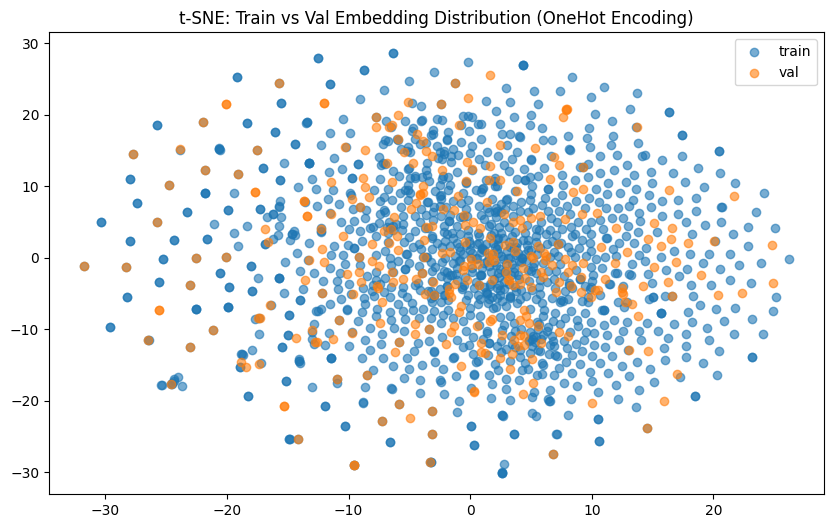

In [30]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(10, 6))
for split in ['train', 'val']:
    idxs = [i for i, s in enumerate(all_split) if s == split]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=split, alpha=0.6)

plt.legend()
plt.title("t-SNE: Train vs Val Embedding Distribution (OneHot Encoding)")
plt.show()

### 1.4 Visualizing onehot embeddings: Train Categories vs. Val Categories

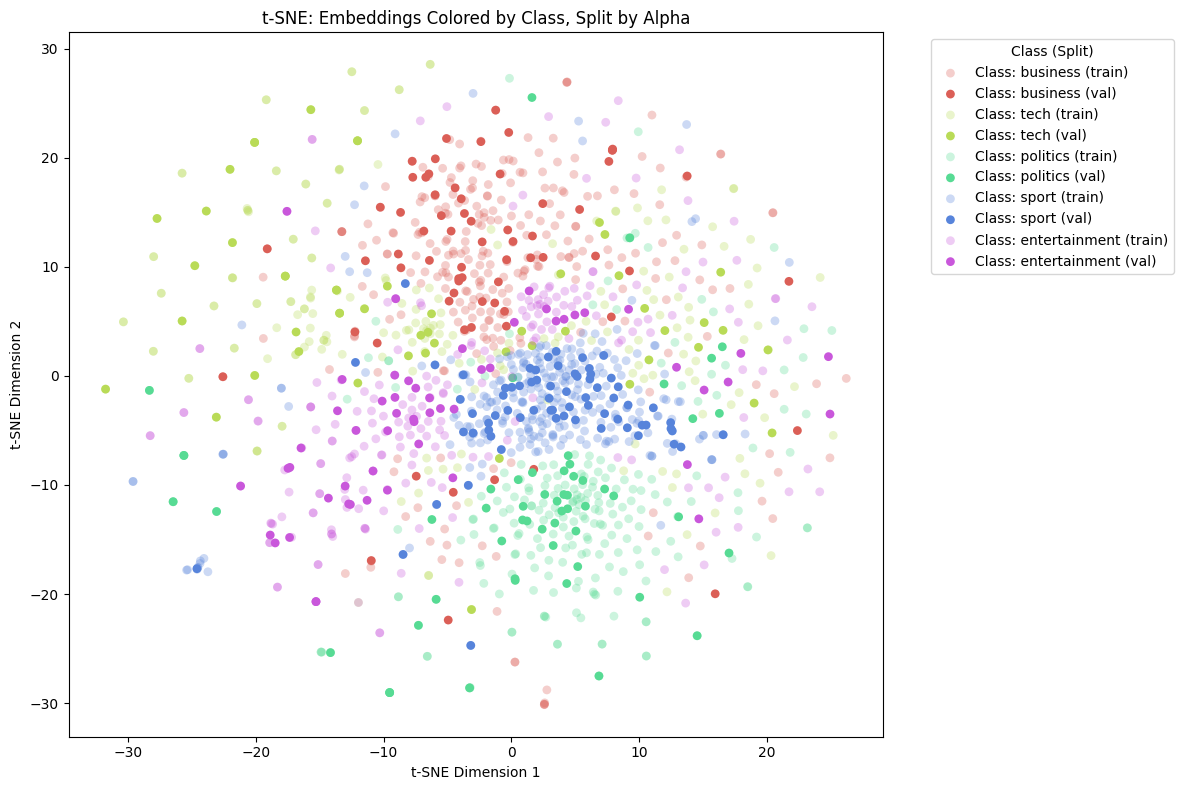

In [31]:
# Color map for classes
unique_classes = sorted(set(all_labels))
palette = sns.color_palette("hls", len(unique_classes))
label_to_color = {label: palette[i] for i, label in enumerate(unique_classes)}

# Plot
plt.figure(figsize=(12, 8))

for label in unique_classes:
    for split_type, alpha_val in [('train', 0.3), ('val', 1)]:
        idxs = [i for i, (lbl, split) in enumerate(zip(all_labels, all_split))
                if lbl == label and split == split_type]
        plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1],
                    label=f'Class: {label_dict[label]} ({split_type})',
                    color=label_to_color[label],
                    alpha=alpha_val,
                    edgecolors='none',
                    s=40)

plt.legend(title='Class (Split)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE: Embeddings Colored by Class, Split by Alpha")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

## 2. TF-IDF Encoding

### 2.1. Vectorizing text using glove embeddings

In [32]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(train_texts['Clean_text'])

tfidf_matrix = np.asarray(tfidf_matrix.toarray())

# Get the feature names (i.e., terms in the vocabulary)
train_feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a dense format (for better visualization)
X_train_dense_matrix = tfidf_matrix#.todense()

In [33]:
# Fit and transform the documents
tfidf_matrix = vectorizer.transform(val_texts['Clean_text'])

tfidf_matrix = np.asarray(tfidf_matrix.toarray())

# Get the feature names (i.e., terms in the vocabulary)
train_feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a dense format (for better visualization)
X_val_dense_matrix = tfidf_matrix#.todense()

In [34]:
X_train_dense_matrix.shape, X_val_dense_matrix.shape

((1192, 17428), (298, 17428))

### 2.1 Save Embeddings

In [35]:
save_embeddings(SAVE_PATH, 'X_train_tfidf_embeddings.pkl', X_train_dense_matrix)
save_embeddings(SAVE_PATH, 'X_val_tfidf_embeddings.pkl', X_val_dense_matrix)

Successfully saved at : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_train_tfidf_embeddings.pkl
Successfully saved at : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_val_tfidf_embeddings.pkl


### 2.2 Loading Embeddings

In [36]:
X_train_tfidf_data = load_embeddings(SAVE_PATH, 'X_train_tfidf_embeddings.pkl')
X_test_tfidf_data = load_embeddings(SAVE_PATH, 'X_val_tfidf_embeddings.pkl')
# shape
X_train_tfidf_data.shape, X_test_tfidf_data.shape

Loaded from : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_train_tfidf_embeddings.pkl
Loaded from : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_val_tfidf_embeddings.pkl


((1192, 17428), (298, 17428))

In [38]:
X_train = X_train_tfidf_data.copy()
X_val = X_test_tfidf_data.copy()

all_embs = np.vstack([X_train, X_val])
# all_labels = train_labels + val_labels
all_labels = list(train_labels) + list(val_labels)
all_split = ['train'] * len(X_train) + ['val'] * len(X_val)

### 1.3 Visualizing tf-idf embeddings: Train vs. Val

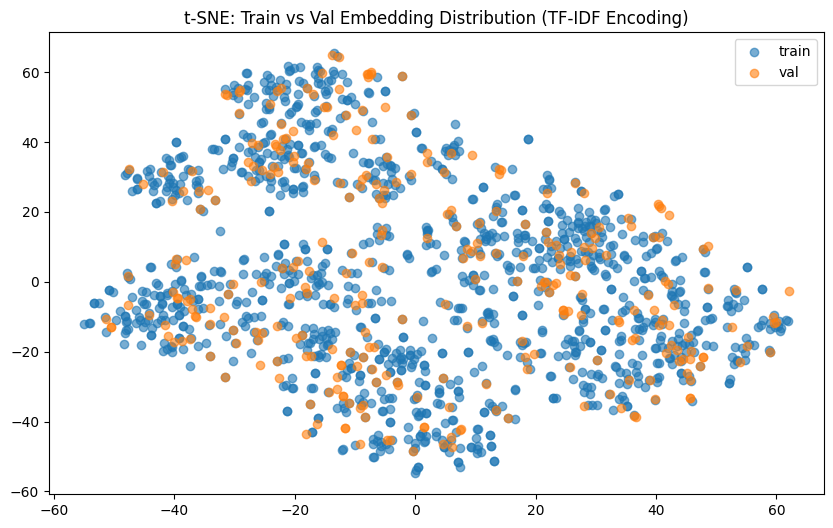

In [39]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(10, 6))
for split in ['train', 'val']:
    idxs = [i for i, s in enumerate(all_split) if s == split]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=split, alpha=0.6)

plt.legend()
plt.title("t-SNE: Train vs Val Embedding Distribution (TF-IDF Encoding)")
plt.show()

### 1.4 Visualizing onehot embeddings: Train Categories vs. Val Categories

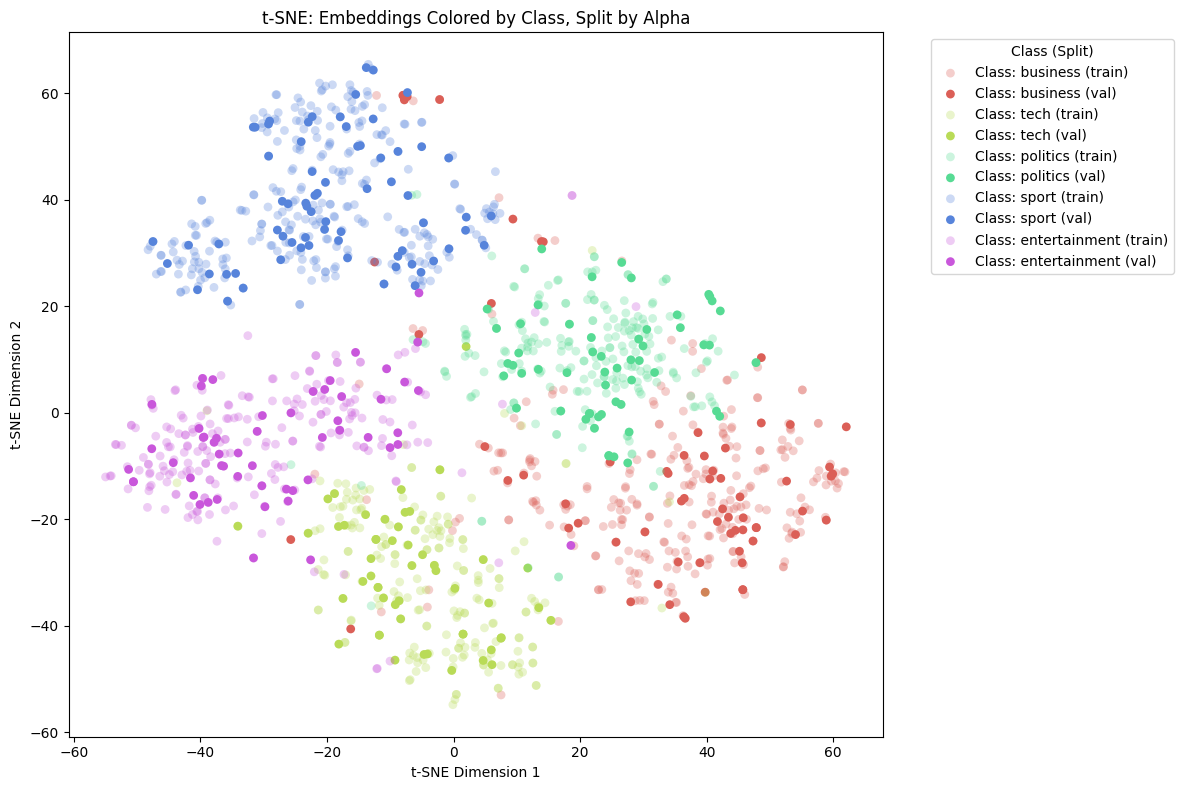

In [40]:
# Color map for classes
unique_classes = sorted(set(all_labels))
palette = sns.color_palette("hls", len(unique_classes))
label_to_color = {label: palette[i] for i, label in enumerate(unique_classes)}

# Plot
plt.figure(figsize=(12, 8))

for label in unique_classes:
    for split_type, alpha_val in [('train', 0.3), ('val', 1)]:
        idxs = [i for i, (lbl, split) in enumerate(zip(all_labels, all_split))
                if lbl == label and split == split_type]
        plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1],
                    label=f'Class: {label_dict[label]} ({split_type})',
                    color=label_to_color[label],
                    alpha=alpha_val,
                    edgecolors='none',
                    s=40)

plt.legend(title='Class (Split)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE: Embeddings Colored by Class, Split by Alpha")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

## 3.Word2Vec Embeddings

**Approach 1**

In [ ]:
# github mirror
git lfs install
git clone https://github.com/mmihaltz/word2vec-GoogleNews-vectors.git
cd word2vec-GoogleNews-vectors
# You'll find GoogleNews-vectors-negative300.bin.gz (~1.5 GB)

In [ ]:
!gunzip GoogleNews-vectors-negative300.bin.gz

**Approach 2**

- takes 6 min to download

In [41]:
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')  # downloads and caches automatically

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [42]:
def vectorizing_to_word2vec(X, word2vec_model):
    # vectorizing comment in data using word2vec embeddings
    start = datetime.now()
    word2vec_data = []
    for comment in X:
        vector = np.zeros(300)
        for word in comment.split():
            if word in word2vec_model:
                vec = word2vec_model[word]
            else:
                vec = np.zeros(300)
            vector += vec
        word2vec_data.append(vector)
    word2vec_data = np.array(word2vec_data)
    print("Time taken: ", datetime.now() - start)
    return word2vec_data

### 3.1. Vectorizing text using word2vec embeddings

In [43]:
# vectorizing
X_train_word2vec_data = vectorizing_to_word2vec(train_texts['Clean_text'], word2vec_model)
# embedding
save_embeddings(SAVE_PATH, 'X_train_word2vec_embeddings.pkl', X_train_word2vec_data)
# checking shape
X_train_word2vec_data.shape

Time taken:  0:00:01.562824
Successfully saved at : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_train_word2vec_embeddings.pkl


(1192, 300)

In [44]:
# vectorizing
X_test_word2vec_data = vectorizing_to_word2vec(val_texts['Clean_text'], word2vec_model)
# embedding
save_embeddings(SAVE_PATH, 'X_test_word2vec_embeddings.pkl', X_test_word2vec_data)
# checking shape
X_test_word2vec_data.shape

Time taken:  0:00:00.207899
Successfully saved at : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_test_word2vec_embeddings.pkl


(298, 300)

### 3.2 Loading saved word2vec embeddings

In [45]:
X_train_word2vec_data = load_embeddings(SAVE_PATH, 'X_train_word2vec_embeddings.pkl')
X_train_word2vec_data.shape

Loaded from : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_train_word2vec_embeddings.pkl


(1192, 300)

In [46]:
X_test_word2vec_data = load_embeddings(SAVE_PATH, 'X_test_word2vec_embeddings.pkl')
X_test_word2vec_data.shape

Loaded from : /Users/rahulshelke/Documents/Data-Science/Data-Science-Projects/bbc-news-sorting/notebooks/embeddings/X_test_word2vec_embeddings.pkl


(298, 300)

### 3.3 Visualizing word2vec embeddings: Train vs. Val

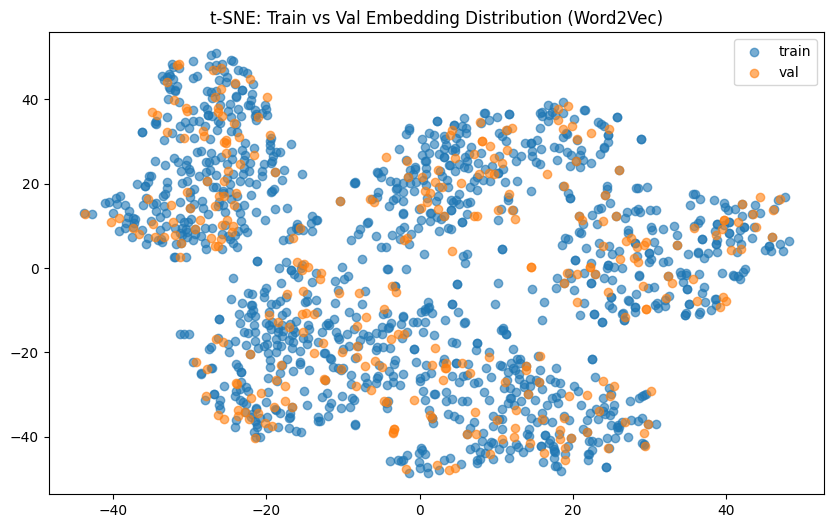

In [47]:
X_train = X_train_word2vec_data.copy()
X_val = X_test_word2vec_data.copy()

all_embs = np.vstack([X_train, X_val])
all_labels = list(train_labels) + list(val_labels)
all_split = ['train'] * len(X_train) + ['val'] * len(X_val)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(10, 6))
for split in ['train', 'val']:
    idxs = [i for i, s in enumerate(all_split) if s == split]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=split, alpha=0.6)

plt.legend()
plt.title("t-SNE: Train vs Val Embedding Distribution (Word2Vec)")
plt.show()

### 3.4 Visualizing word2vec embeddings: Train Categories vs. Val Categories

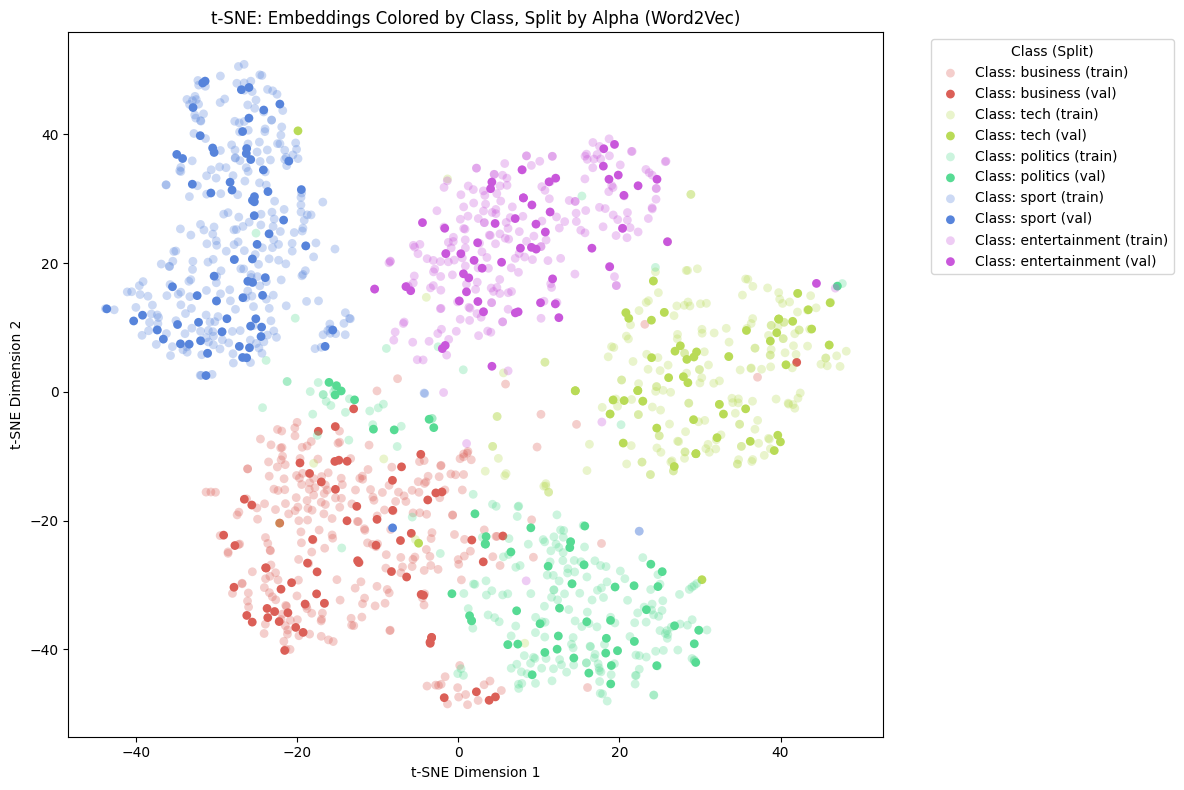

In [48]:
# Color map for classes
unique_classes = sorted(set(all_labels))
palette = sns.color_palette("hls", len(unique_classes))
label_to_color = {label: palette[i] for i, label in enumerate(unique_classes)}

# Plot
plt.figure(figsize=(12, 8))

for label in unique_classes:
    for split_type, alpha_val in [('train', 0.3), ('val', 1)]:
        idxs = [i for i, (lbl, split) in enumerate(zip(all_labels, all_split))
                if lbl == label and split == split_type]
        plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1],
                    label=f'Class: {label_dict[label]} ({split_type})',
                    color=label_to_color[label],
                    alpha=alpha_val,
                    edgecolors='none',
                    s=40)

plt.legend(title='Class (Split)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE: Embeddings Colored by Class, Split by Alpha (Word2Vec)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

## 4.Glove Embeddings

In [53]:
os.makedirs("embeddings", exist_ok=True)

In [65]:
# !wget -P embeddings http://nlp.stanford.edu/data/glove.6B.zip # for linux

In [66]:
# !curl -L -o embeddings/glove.6B.zip http://nlp.stanford.edu/data/glove.6B.zip # for macOS

In [69]:
!unzip ./embeddings/glove.6B.zip

Archive:  ./embeddings/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [74]:
GLOVE_EMBEDDING_PATH = "./embeddings/glove.6B.300d.txt"

In [75]:
# loading pre-trained glove embeddings
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

### 4.1. Vectorizing text using glove embeddings

In [76]:
# loading pre-trained glove embeddings
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model

In [77]:
model = loadGloveModel(GLOVE_EMBEDDING_PATH)

Loading Glove Model
Done. 400000  words loaded!


In [81]:
# vectorizing comment in train data using glove embeddings
start = datetime.now()
glove_train = []
for comment in train_texts['Clean_text']:
    vector = np.zeros(300)
    for word in comment.split():
        if word in model.keys():
            vector += model[word]
    glove_train.append(vector)
glove_train = np.array(glove_train)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:00.198687


In [82]:
# shape of train data embeddings
glove_train.shape

(1192, 300)

In [83]:
# saving embeddings for train data column comment
with open(os.path.join(SAVE_PATH, 'glove_text_train.npy'), 'wb') as f:
    np.save(f, glove_train)
print("Embeddings saved successfully!")

Embeddings saved successfully!


In [84]:
# vectorizing comment in test data using glove embeddings
start = datetime.now()
glove_test = []
for comment in val_texts['Clean_text']:
    vector = np.zeros(300)
    for word in comment.split():
        if word in model.keys():
            vector += model[word]
    glove_test.append(vector)
glove_test = np.array(glove_test)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:00.048669


In [85]:
# shape of test data embeddings
glove_test.shape

(298, 300)

In [86]:
# saving embeddings for test data column comment
with open(os.path.join(SAVE_PATH, 'glove_text_test.npy'), 'wb') as f:
    np.save(f, glove_test)
print("Embeddings saved successfully!")

Embeddings saved successfully!


### 4.2 Loading saved glove embeddings

In [87]:
# loading embeddings for train data column comment
with open(os.path.join(SAVE_PATH, 'glove_text_train.npy'), 'rb') as f:
    glove_train = np.load(f)
print("Train Embeddings Shape: ", glove_train.shape)
f.close()

Train Embeddings Shape:  (1192, 300)


In [88]:
# loading embeddings for test data column comment
with open(os.path.join(SAVE_PATH, 'glove_text_test.npy'), 'rb') as f:
    glove_test = np.load(f)
print("Test Embeddings Shape: ", glove_test.shape)
f.close()

Test Embeddings Shape:  (298, 300)


### 4.3 Visualizing glove embeddings: Train vs. Val

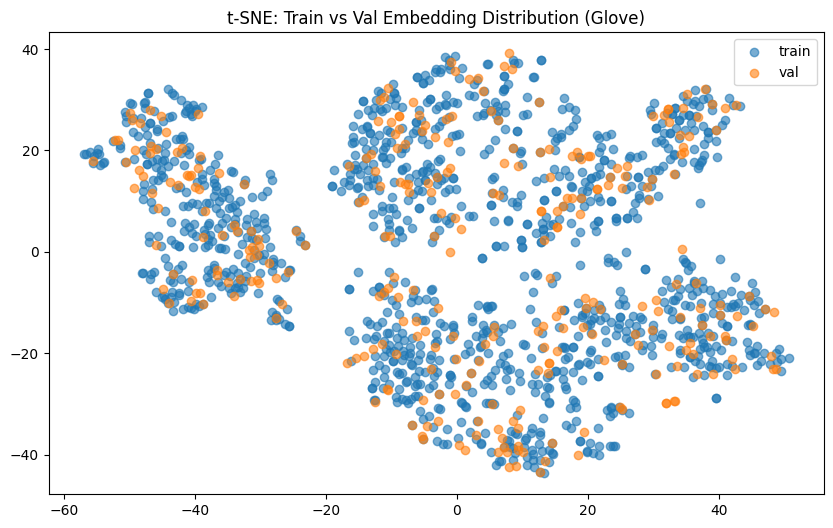

In [90]:
X_train = glove_train.copy()
X_val = glove_test.copy()

all_embs = np.vstack([X_train, X_val])
all_labels = list(train_labels) + list(val_labels)
all_split = ['train'] * len(X_train) + ['val'] * len(X_val)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(10, 6))
for split in ['train', 'val']:
    idxs = [i for i, s in enumerate(all_split) if s == split]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=split, alpha=0.6)

plt.legend()
plt.title("t-SNE: Train vs Val Embedding Distribution (Glove)")
plt.show()

### 4.4 Visualizing glove embeddings: Train Categories vs. Val Categories

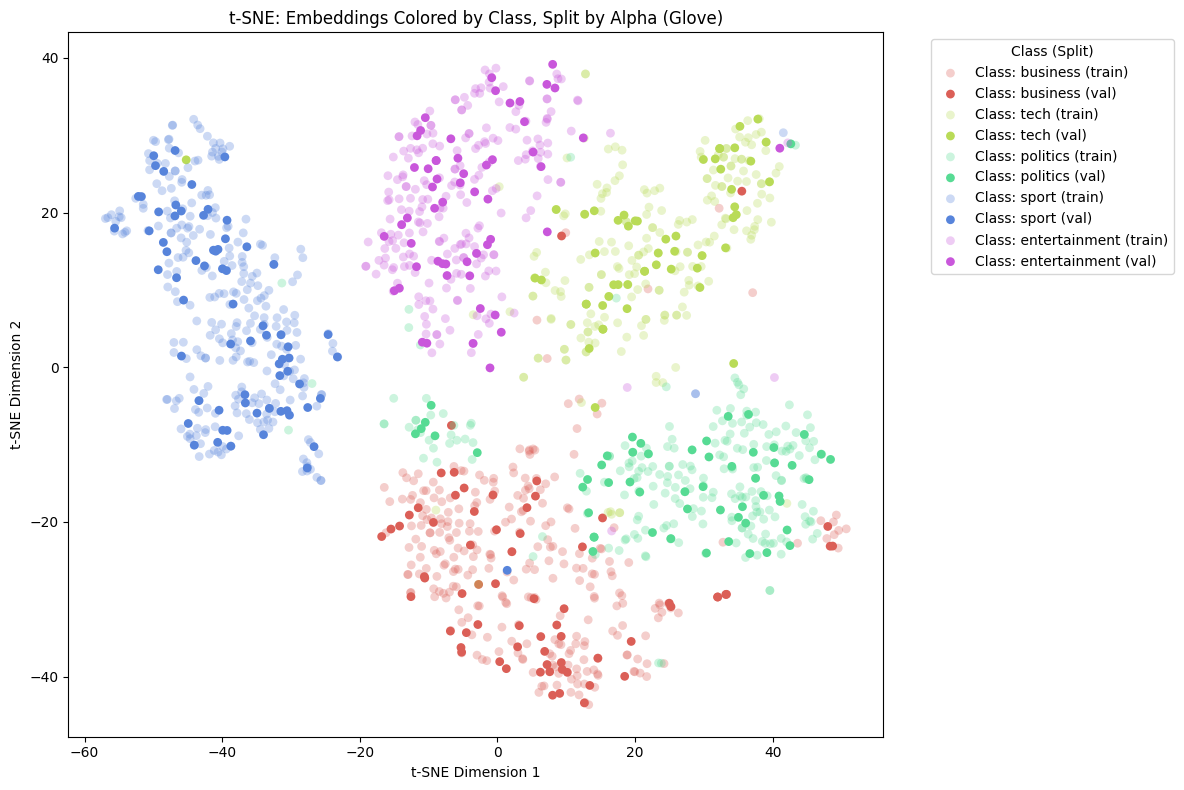

In [91]:
# Color map for classes
unique_classes = sorted(set(all_labels))
palette = sns.color_palette("hls", len(unique_classes))
label_to_color = {label: palette[i] for i, label in enumerate(unique_classes)}

# Plot
plt.figure(figsize=(12, 8))

for label in unique_classes:
    for split_type, alpha_val in [('train', 0.3), ('val', 1)]:
        idxs = [i for i, (lbl, split) in enumerate(zip(all_labels, all_split))
                if lbl == label and split == split_type]
        plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1],
                    label=f'Class: {label_dict[label]} ({split_type})',
                    color=label_to_color[label],
                    alpha=alpha_val,
                    edgecolors='none',
                    s=40)

plt.legend(title='Class (Split)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE: Embeddings Colored by Class, Split by Alpha (Glove)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

## 5. FastText Embeddings

**Approach 1**

- takes 7 min to download

In [106]:
!wget -P embeddings https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2025-07-14 11:07:32--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.111.125, 18.239.111.120, 18.239.111.129, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.111.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘embeddings/cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  11.5MB/s    in 6m 15s  

2025-07-14 11:13:46 (11.5 MB/s) - ‘embeddings/cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [108]:
!gunzip ./embeddings/cc.en.300.bin.gz

In [111]:
FASTTEXT_EMBEDDING_PATH = "./embeddings/cc.en.300.bin"

In [113]:
ft = fasttext.load_model(FASTTEXT_EMBEDDING_PATH)
ft.get_dimension()

300

**Approach 2**

- takes 5 min to download

In [ ]:
# Load pre-trained FastText model (English)
# ft = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# len(ft.key_to_index), ft.vector_size # ~1 million words

(999999, 300)

In [ ]:
# ft['hello']

### 5.1. Vectorizing text using fasttext embeddings

In [114]:
# vectorizing comment in train data using fast embeddings
start = datetime.now()
fasttext_train = []
for comment in train_texts['Clean_text']:
    vector = np.zeros(300)
    for word in comment.split():
        vec = ft.get_word_vector(word)
        vector += vec
    fasttext_train.append(vector)
fasttext_train = np.array(fasttext_train)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:09.561393


In [124]:
with open(os.path.join(SAVE_PATH, 'X_train_fasttext_embeddings.pkl'), 'wb') as f:
    pickle.dump(fasttext_train, f)

In [125]:
fasttext_train.shape

(1192, 300)

In [126]:
# vectorizing comment in train data using fast embeddings
start = datetime.now()
fasttext_val = []
for comment in val_texts['Clean_text']:
    vector = np.zeros(300)
    for word in comment.split():
        vec = ft.get_word_vector(word)
        vector += vec
    fasttext_val.append(vector)
fasttext_val = np.array(fasttext_val)
print("Time taken: ", datetime.now() - start)

Time taken:  0:00:00.327756


In [127]:
with open(os.path.join(SAVE_PATH, 'X_val_fasttext_embeddings.pkl'), 'wb') as f:
    pickle.dump(fasttext_val, f)

In [129]:
fasttext_val.shape

(298, 300)

### 5.2. Loading Saved fasttext embeddings

In [130]:
with open(os.path.join(SAVE_PATH, 'X_train_fasttext_embeddings.pkl'), 'rb') as f:
     fasttext_train = pickle.load(f)

fasttext_train.shape

(1192, 300)

In [131]:
with open(os.path.join(SAVE_PATH, 'X_val_fasttext_embeddings.pkl'), 'rb') as f:
     fasttext_val = pickle.load(f)

fasttext_val.shape

(298, 300)

### 5.3 Visualizing fasttext embeddings: Train vs. Val

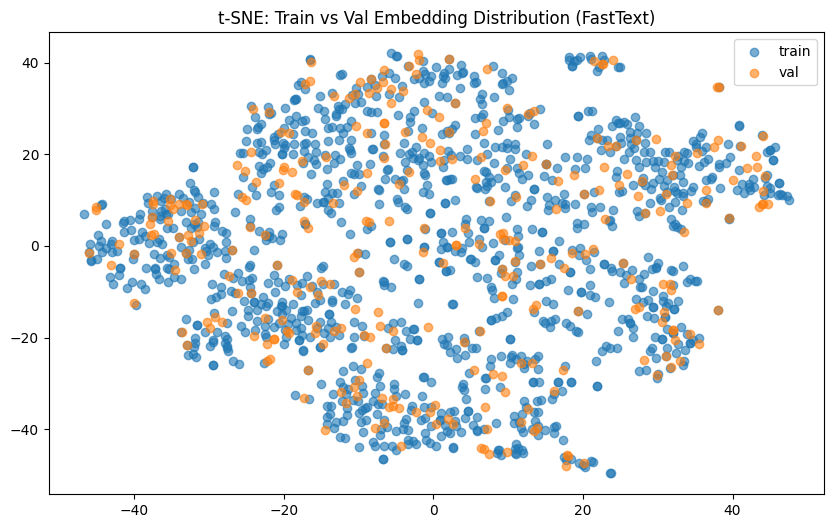

In [132]:
X_train = fasttext_train.copy()
X_val = fasttext_val.copy()

all_embs = np.vstack([X_train, X_val])
all_labels = list(train_labels) + list(val_labels)
all_split = ['train'] * len(X_train) + ['val'] * len(X_val)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(10, 6))
for split in ['train', 'val']:
    idxs = [i for i, s in enumerate(all_split) if s == split]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=split, alpha=0.6)

plt.legend()
plt.title("t-SNE: Train vs Val Embedding Distribution (FastText)")
plt.show()

### 5.4 Visualizing fasttext embeddings: Train Categories vs. Val Categories

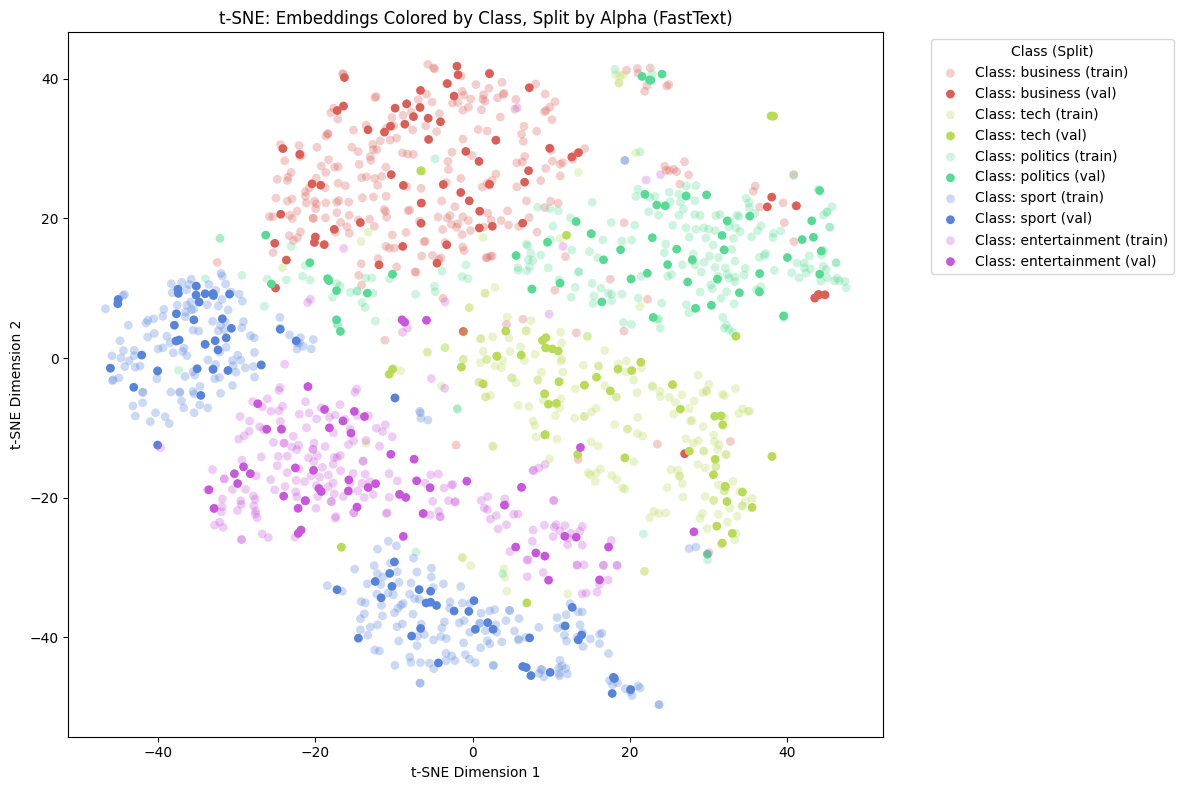

In [133]:
# Color map for classes
unique_classes = sorted(set(all_labels))
palette = sns.color_palette("hls", len(unique_classes))
label_to_color = {label: palette[i] for i, label in enumerate(unique_classes)}

# Plot
plt.figure(figsize=(12, 8))

for label in unique_classes:
    for split_type, alpha_val in [('train', 0.3), ('val', 1)]:
        idxs = [i for i, (lbl, split) in enumerate(zip(all_labels, all_split))
                if lbl == label and split == split_type]
        plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1],
                    label=f'Class: {label_dict[label]} ({split_type})',
                    color=label_to_color[label],
                    alpha=alpha_val,
                    edgecolors='none',
                    s=40)

plt.legend(title='Class (Split)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE: Embeddings Colored by Class, Split by Alpha (FastText)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

## 6.BERT Embeddings

In [134]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set model to evaluation mode

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [135]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU
    print("✅ Using Apple MPS (Metal Performance Shaders)")
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
    print("✅ Using CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")  # CPU fallback
    print("⚠️ Using CPU (no GPU acceleration)")

model.to(device)

✅ Using Apple MPS (Metal Performance Shaders)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Use [CLS] token embedding (first token) as sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
    return cls_embedding.squeeze().cpu().numpy()#.astype(np.float32)  # Convert to numpy array

### 5.1. Vectorizing text using BERT embeddings

In [137]:
# Convert all clean_text to BERT embeddings
train_embeddings = []

for text in tqdm(train_texts['Clean_text']):
    emb = get_bert_embedding(str(text))
    train_embeddings.append(emb)

100%|██████████| 1192/1192 [01:44<00:00, 11.36it/s]


In [138]:
train_bert_embeddings = np.array(train_embeddings)

In [139]:
with open(os.path.join(SAVE_PATH, 'bert_embedding_train.pkl'), 'wb') as f:
    pickle.dump(train_bert_embeddings, f)

In [140]:
train_bert_embeddings.shape

(1192, 768)

In [142]:
# Convert all clean_text to BERT embeddings
val_embeddings = []

for text in tqdm(val_texts['Clean_text']):
    emb = get_bert_embedding(str(text))
    val_embeddings.append(emb)

100%|██████████| 298/298 [00:25<00:00, 11.49it/s]


In [143]:
val_bert_embeddings = np.array(val_embeddings)

In [144]:
with open(os.path.join(SAVE_PATH, 'bert_embedding_val.pkl'), 'wb') as f:
    pickle.dump(val_bert_embeddings, f)

In [145]:
val_bert_embeddings.shape

(298, 768)

### 5.2. Loading Saved BERT embeddings

In [146]:
with open(os.path.join(SAVE_PATH, 'bert_embedding_train.pkl'), 'rb') as f:
     train_bert_embeddings = pickle.load(f)
train_bert_embeddings.shape

(1192, 768)

In [147]:
with open(os.path.join(SAVE_PATH, 'bert_embedding_val.pkl'), 'rb') as f:
     val_bert_embeddings = pickle.load(f)
val_bert_embeddings.shape

(298, 768)

In [152]:
type(train_bert_embeddings.to(dtype=torch.float32))

AttributeError: 'numpy.ndarray' object has no attribute 'to'

### 5.3 Visualizing BERT embeddings: Train vs. Val

In [150]:
X_train = train_bert_embeddings.to(dtype=torch.float32).copy()
X_val = val_bert_embeddings.to(dtype=torch.float32).copy()

all_embs = np.vstack([X_train, X_val])
all_labels = list(train_labels) + list(val_labels)
all_split = ['train'] * len(X_train) + ['val'] * len(X_val)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(all_embs)

# Plot
plt.figure(figsize=(10, 6))
for split in ['train', 'val']:
    idxs = [i for i, s in enumerate(all_split) if s == split]
    plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=split, alpha=0.6)
plt.legend()
plt.title("t-SNE: Train vs Val Embedding Distribution (BERT Embeddings)")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to'

### 5.4 Visualizing BERT embeddings: Train Categories vs. Val Categories

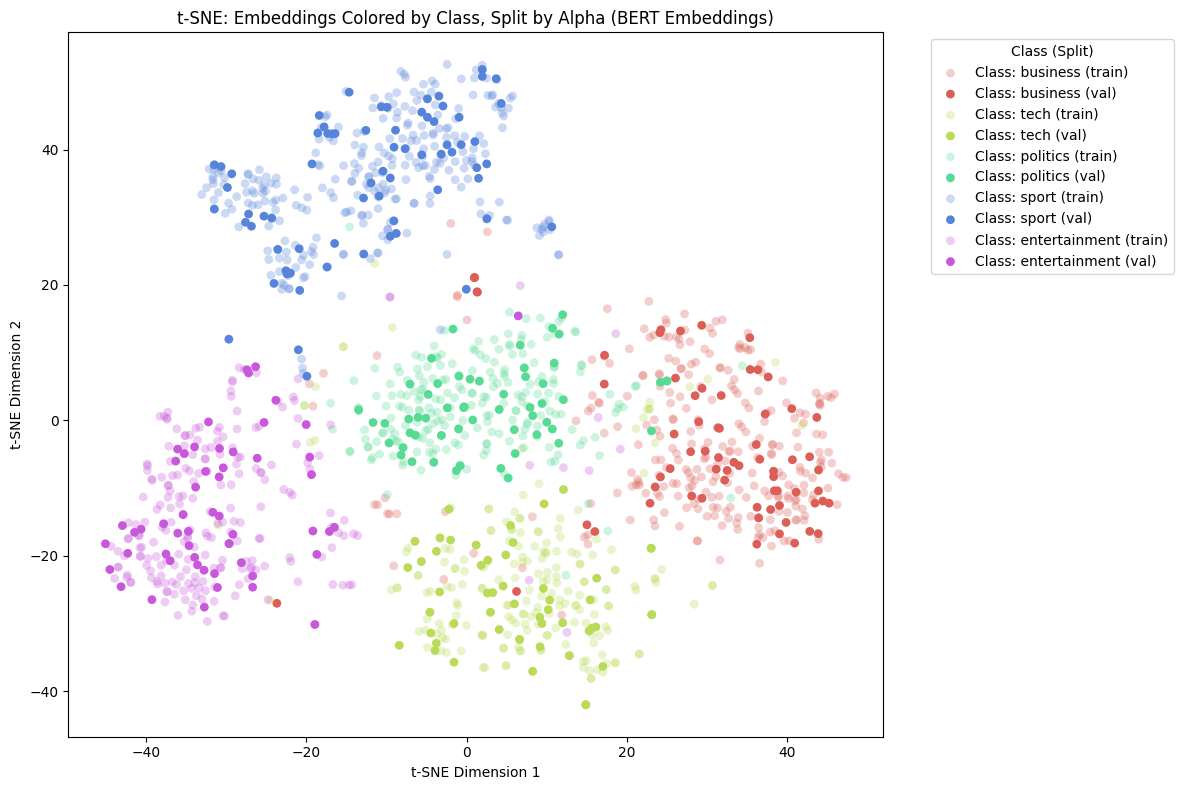

In [149]:
# Color map for classes
unique_classes = sorted(set(all_labels))
palette = sns.color_palette("hls", len(unique_classes))
label_to_color = {label: palette[i] for i, label in enumerate(unique_classes)}

# Plot
plt.figure(figsize=(12, 8))

for label in unique_classes:
    for split_type, alpha_val in [('train', 0.3), ('val', 1)]:
        idxs = [i for i, (lbl, split) in enumerate(zip(all_labels, all_split))
                if lbl == label and split == split_type]
        plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1],
                    label=f'Class: {label_dict[label]} ({split_type})',
                    color=label_to_color[label],
                    alpha=alpha_val,
                    edgecolors='none',
                    s=40)

plt.legend(title='Class (Split)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE: Embeddings Colored by Class, Split by Alpha (BERT Embeddings)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()